Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from category_encoders.target_encoder import TargetEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = 100

Загрузка обучающего и тестового датасетов

Разметка полей. def - таргет для модели. id - идентификатор. Все остальные поля - факторы для обучения модели

In [2]:
train = pd.read_csv('data/logreg_train.csv')
test = pd.read_csv('data/logreg_test.csv')

In [3]:
purpose = [x for x in train.columns if x.startswith('purpose_')]
subgrade = [x for x in train.columns if x.startswith('sub_grade_')]
home_ownership = [x for x in train.columns if x.startswith('home_ownership_')]

train['purpose'] = train[purpose].idxmax(axis=1)
# train.drop(columns=purpose, axis=1, inplace=True)
train['subgrade'] = train[subgrade].idxmax(axis=1)
# train.drop(columns=subgrade, axis=1, inplace=True)
train['home_ownership'] = train[home_ownership].idxmax(axis=1)
# train.drop(columns=home_ownership, axis=1, inplace=True)

test['purpose'] = test[purpose].idxmax(axis=1)
# test.drop(columns=purpose, axis=1, inplace=True)
test['subgrade'] = test[subgrade].idxmax(axis=1)
# test.drop(columns=subgrade, axis=1, inplace=True)
test['home_ownership'] = test[home_ownership].idxmax(axis=1)
# test.drop(columns=home_ownership, axis=1, inplace=True)

cols = [
    'purpose', 'home_ownership', 'subgrade', 'emp_length', 'term', 'delinq_2yrs', 'num_accts_ever_120_pd', 'acc_open_past_24mths',
]
te = TargetEncoder(cols=cols)
sample_df = te.fit_transform(train[cols], train['def'])
test_sample_df = te.transform(test[cols])

sample_df.columns = [f"{x}_encoded" for x in sample_df.columns]
test_sample_df.columns = [f"{x}_encoded" for x in test_sample_df.columns]

d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [4]:
train = pd.concat([train, sample_df], axis=1)
test = pd.concat([test, test_sample_df], axis=1)

In [5]:
targ_cols = [i for i in train.columns if i not in ['def', 'id']  and 'sub_grade' not in i]

X_train = train[targ_cols]
X_test = test[targ_cols]

y_train = train["def"]

Обучение модели

In [6]:
knn_params = {
    "fit_intercept": True,
    "max_iter": 300,
    "penalty": "l1",
    "random_state": 123,
    "solver": "liblinear"
}

model = LogisticRegression(**knn_params)

cols = [
    'percent_per_year',
    'percent',
    'term',
    'loan_income_ratio',
    'psk',
    'additional_dti',
    
    'purpose_small_business',
    'purpose_home_improvement',
    'purpose_major_purchase',
    'purpose_medical',
    'purpose_vacation',
    'purpose_wedding',
    'purpose_car',
    
    'acc_open_past_24mths',
    'num_accts_ever_120_pd',
    
    'home_ownership_MORTGAGE',
    'home_ownership_RENT',
    
    'installment',
    'is_first_loan',
    'avg_cur_bal',
    'is_emp_length_unknown',
    'even_salary',
]

skf = StratifiedKFold(n_splits=5, random_state=16, shuffle=True)
scores = cross_val_score(model, X_train[cols], y_train, cv=skf, scoring='roc_auc')
print(np.mean(scores), np.std(scores))

0.6859147742494416 0.007224020156917809


In [14]:
def do_lr_cv(x_train, x_test, y_train, features, params):
    oof_result = pd.Series([0] * x_train.shape[0], index=x_train.index)
    result = [0] * x_test.shape[0]
    scores = []
    models = []
    for ind_trn, ind_test in skf.split(x_train, y_train):
        X_train_df = x_train[features].iloc[ind_trn]
        X_valid_df = x_train[features].iloc[ind_test]
        y_train_df = y_train.iloc[ind_trn]
        y_valid_df = y_train.iloc[ind_test]

        model = LogisticRegression(**params)
        model.fit(X_train_df, y_train_df)

        scores.append(roc_auc_score(y_valid_df, model.predict_proba(X_valid_df)[:, 1]))
        result += model.predict_proba(x_test[features])[:, 1:].flatten()/5
        oof_result.loc[X_valid_df.index] = model.predict_proba(X_valid_df)[:, 1]
        models.append(model)
    return scores, result, oof_result, models

In [ ]:
remove_list = [
    'purpose', 'home_ownership', 'subgrade',
    'additional_dti', 'delinq_2yrs_encoded',
    'dti', 'dti_sqrt',
    'emp_length_encoded', 'even_installment',
    'funded_amnt',
    'installment',
    'term_encoded',
    'emp_length', 'funded_amnt_sqrt', 
    'waste_to_installment_ratio',
    'delinq_amnt', 'funded_amnt_mod_1000',
    'term', 'funded_amnt_mod_500',
    'num_tl_90g_dpd_24m', 'funded_amnt_mod_100',
    'mths_since_recent_inq',
    'tot_hi_cred_lim_funded_amnt_ratio', 'acc_open_past_24mths_ratio', 'funded_amnt_mod_10',
    
    'dti_ratio_min', 'delinq_2yrs',
    'is_common_amount', 'inq_last_6mths',
    
    
    
    'is_dti_b_35', 
    'purpose_debt_consolidation',
    'installment_log',
    'avg_cur_bal_sqrt',
    'avg_cur_bal',
    'tot_hi_cred_lim_sqrt',
    'tot_hi_cred_lim',
    'acc_open_past_24mths',
    'annual_inc_log',
    'annual_inc',
    'percent_per_year',
    'num_accts_ever_120_pd',
    
    'purpose_encoded',
    'purpose_renewable_energy',
    'purpose_other',
    'purpose_medical',
    'purpose_moving',
    'purpose_house',
    'purpose_car',
    'purpose_credit_card',
    
    'home_ownership_NONE',
    'home_ownership_OTHER',
    'home_ownership_RENT',
    'home_ownership_OWN',
    'home_ownership_MORTGAGE'
]

skf = StratifiedKFold(n_splits=5, random_state=16, shuffle=True)

params = {
    "fit_intercept": True,
    "max_iter": 300,
    "penalty": "l1",
    "random_state": 123,
    "solver": "liblinear",
    "C": 5
}

cols = targ_cols.copy()

for r_c in remove_list:
    cols.remove(r_c)

scores, result, oof_result, models = do_lr_cv(
    X_train,
    X_test,
    y_train,
    cols,
    params,
)

In [ ]:
# C 1 log
np.mean(scores), np.std(scores), roc_auc_score(y_train, oof_result)

In [206]:
# C 1.6 log
np.mean(scores), np.std(scores), roc_auc_score(y_train, oof_result)

(0.6895404466266455, 0.006726686825808151, 0.6895443389561552)

In [207]:
sorted(list(zip(np.mean([model.coef_[0] for model in models], axis=0), cols)))

[(-0.8466551494311446, 'purpose_vacation'),
 (-0.5015632164120405, 'installment_sqrt'),
 (-0.35196363228784533, 'purpose_wedding'),
 (-0.2967154761814058, 'tot_hi_cred_lim_log'),
 (-0.20875345827569225, 'chargeoff_within_12_mths'),
 (-0.16506392962530905, 'is_first_loan'),
 (-0.1438152137257676, 'dti_ratio_max'),
 (0.021778224296561677, 'percent'),
 (0.04318022366312186, 'avg_cur_bal_log'),
 (0.05435852647107041, 'annual_inc_sqrt'),
 (0.05826374327935533, 'residual_dti'),
 (0.08437499594088019, 'even_salary'),
 (0.10236899142190052, 'tot_hi_cred_lim_annual_inc_ratio'),
 (0.1056332461810118, 'purpose_home_improvement'),
 (0.13159774030933047, 'loan_income_ratio'),
 (0.15286661963765585, 'purpose_major_purchase'),
 (0.19147349747813003, 'psk'),
 (0.2023686422724525, 'is_emp_length_unknown'),
 (0.22870207553648844, 'dti_log'),
 (0.26782532115474833, 'is_not_sber_client'),
 (0.28333908102647115, 'funded_amnt_log'),
 (0.6098830954746963, 'purpose_small_business'),
 (1.8004591498828746, 'hom

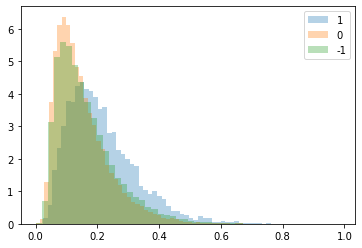

In [208]:
plt.hist(oof_result[y_train == 1], bins=50, alpha=0.33, density='uniform', label='1')
plt.hist(oof_result[y_train == 0], bins=50, alpha=0.33, density='uniform', label='0')
plt.hist(result, bins=50, alpha=0.33, density='uniform', label='-1')
plt.legend()
plt.show()

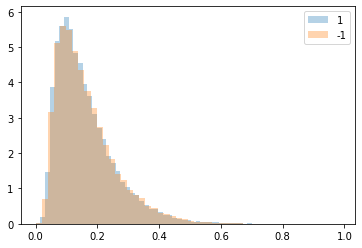

In [209]:
plt.hist(oof_result, bins=50, alpha=0.33, density='uniform', label='1')
plt.hist(result, bins=50, alpha=0.33, density='uniform', label='-1')
plt.legend()
plt.show()

Применение модели к тестовой выборке

In [212]:
test['prob'] = result

Выгрузка решения для коммита в соревновании

In [213]:
test[['id', 'prob']].to_csv('lr_submission.csv', index=False)

In [214]:
test[['id', 'prob']]

,id,prob
0,0,0.116957
1,1,0.125413
2,2,0.217813
3,3,0.147082
4,4,0.115246
...,...,...
29995,29995,0.123579
29996,29996,0.070078
29997,29997,0.268971
29998,29998,0.036997


In [117]:
test[['id', 'prob']]

,id,prob
0,0,0.113271
1,1,0.120397
2,2,0.214433
3,3,0.150375
4,4,0.129360
...,...,...
29995,29995,0.119279
29996,29996,0.051602
29997,29997,0.270260
29998,29998,0.029760
